In [7]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from utils import get_data, min_max_normalize, prepare_data, create_dataloaders, set_seed
from model import MembraneModel, Trainer

# set seed for reproducibility
set_seed(42)

# Pfade
data_csv = '../../../data/interpolation/auswertung_gesamt_8N_10N_12N_15N_17N_18N_20N.csv'
outputh_path = './heatmaps/'

In [8]:
data = get_data(data_csv)
norm_data, _, _ = min_max_normalize(data)

In [9]:
data.head()

,Datei_ID,X,Y,F,Sensor R1,Sensor R2,Sensor R3,Sensor R4,Sensor R5,Sensor R6,Sensor R7,Sensor R8
0,0,-290.0,290.0,8.0,3.204525,3.736075,2.075750,3.186575,3.381575,3.499850,3.244225,3.200625
1,1,-290.0,232.0,8.0,3.168300,3.681725,2.316125,3.176025,3.418725,3.475375,3.233525,3.199025
2,2,-290.0,174.0,8.0,3.174200,3.553550,2.512250,3.165550,3.420850,3.426800,3.222500,3.206325
3,3,-290.0,116.0,8.0,3.169525,3.421750,2.574925,3.159475,3.406800,3.351650,3.208675,3.211225
4,4,-290.0,58.0,8.0,3.223000,3.062850,2.820825,3.139875,3.379850,3.225300,3.178675,3.221750


In [10]:
norm_data.head()

,Datei_ID,X,Y,F,Sensor R1,Sensor R2,Sensor R3,Sensor R4,Sensor R5,Sensor R6,Sensor R7,Sensor R8
0,0,-290.0,290.0,8.0,0.907353,0.995691,0.085711,0.941547,0.837446,0.924390,0.911808,0.879628
1,1,-290.0,232.0,8.0,0.885731,0.966595,0.272775,0.934077,0.863314,0.909594,0.903588,0.876255
2,2,-290.0,174.0,8.0,0.889253,0.897979,0.425403,0.926660,0.864794,0.880230,0.895118,0.891644
3,3,-290.0,116.0,8.0,0.886462,0.827422,0.474178,0.922358,0.855010,0.834801,0.884497,0.901974
4,4,-290.0,58.0,8.0,0.918380,0.635292,0.665541,0.908479,0.836245,0.758420,0.861450,0.924161


## Splitting the Data

In [11]:
batch_size = 64

# Data with x and y only
X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(norm_data, targets='xy')
train_loader_xy, val_loader_xy, test_loader_xy = create_dataloaders(X_train, X_val, X_test, y_train, y_val, y_test, batch_size=batch_size)
# Data with F only
X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(norm_data, targets='f')
train_loader_f, val_loader_f, test_loader_f = create_dataloaders(X_train, X_val, X_test, y_train, y_val, y_test, batch_size=batch_size)
# Data with both xy and F
X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(norm_data, targets='xyf')
train_loader_xyf, val_loader_xyf, test_loader_xyf = create_dataloaders(X_train, X_val, X_test, y_train, y_val, y_test, batch_size=batch_size)

## Training Model

Starting training...
Starting training...
Starting training...
Test Loss XY: 5.7284
Test Loss F: 0.2641
Test Loss XYF: 3.4106


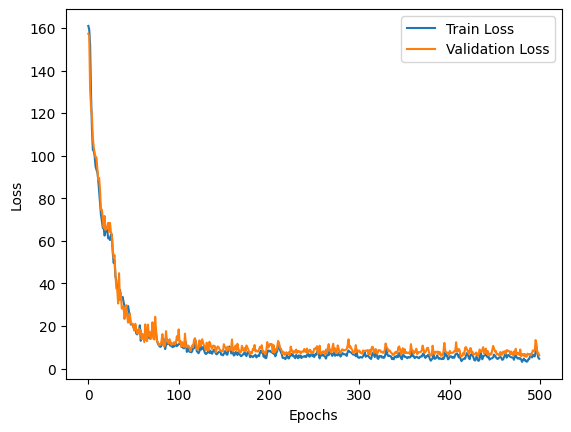

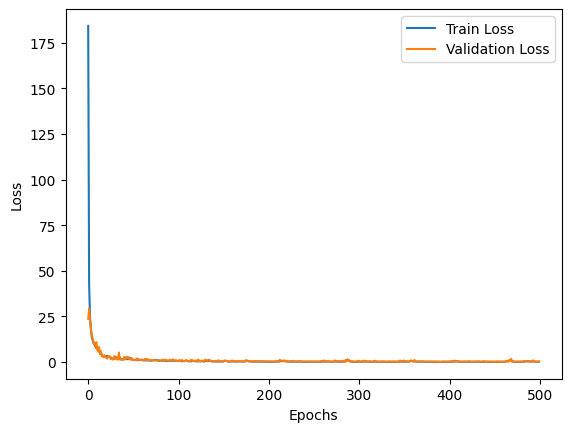

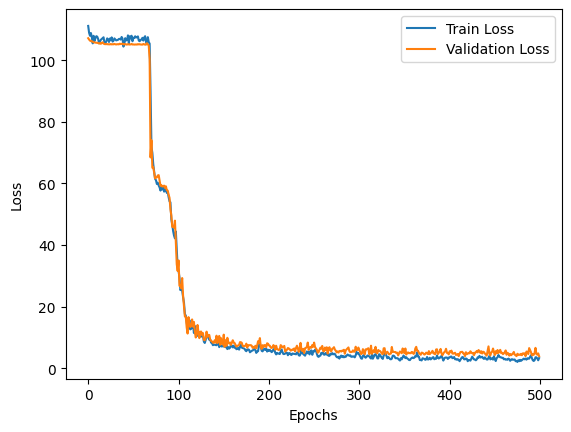

In [12]:
model_xy = MembraneModel(output_dim=2)
model_f = MembraneModel(output_dim=1)
model_xyf = MembraneModel(output_dim=3)

loss_fn_xy = nn.L1Loss()
loss_fn_f = nn.MSELoss()
loss_fn_xyf = nn.L1Loss()
epochs = 500
lr = 0.0013

# Optimizers
optimizer_xy = torch.optim.Adam(model_xy.parameters(), lr=lr)
optimizer_f = torch.optim.Adam(model_f.parameters(), lr=lr)
optimizer_xyf = torch.optim.Adam(model_xyf.parameters(), lr=lr)

# Trainers
trainer_xy = Trainer(model_xy, loss_fn_xy, optimizer_xy, device='cuda')
trainer_f = Trainer(model_f, loss_fn_f, optimizer_f, device='cuda')
trainer_xyf = Trainer(model_xyf, loss_fn_xyf, optimizer_xyf, device='cuda')

# Training
trainer_xy.fit(train_loader_xy, val_loader_xy, epochs=epochs)
trainer_f.fit(train_loader_f, val_loader_f, epochs=epochs)
trainer_xyf.fit(train_loader_xyf, val_loader_xyf, epochs=epochs)

# Test Losses
test_loss_xy = trainer_xy.test(test_loader_xy)
test_loss_f = trainer_f.test(test_loader_f)
test_loss_xyf = trainer_xyf.test(test_loader_xyf)
print(f'Test Loss XY: {test_loss_xy:.4f}')
print(f'Test Loss F: {test_loss_f:.4f}')
print(f'Test Loss XYF: {test_loss_xyf:.4f}')

trainer_xy.plot_losses()
trainer_f.plot_losses()
trainer_xyf.plot_losses()

# Save Models
trainer_xy.save("../../../models/final_models/model_xy.pt")
trainer_f.save("../../../models/final_models/model_f.pt")
trainer_xyf.save("../../../models/final_models/model_xyf.pt")